# setup

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import psycopg
from kneed import KneeLocator
from pgvector.psycopg import register_vector
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [21]:
conn = psycopg.connect(
    dbname="postgres_db",
    user="postgres_user",
    password="postgres_password",
    host="veld_embeddings_platform_run_sql_server",
    port="5432",
)
conn.autocommit = True
register_vector(conn)
cursor = conn.cursor()
cursor.execute("SELECT version();")
print(cursor.fetchone())

('PostgreSQL 17.4 on x86_64-pc-linux-gnu, compiled by gcc (Debian 10.2.1-6) 10.2.1 20210110, 64-bit',)


# load_from_db

In [22]:
l = [1, 2, 3]
print(np.array(l))
print(np.stack(l))

[1 2 3]
[1 2 3]


In [23]:
def load_from_db(lemma_list, limit=None):
    cursor.execute(
        "select lemma, sentence_id, token_index, embedding "
        "from embeddings__dbmdz__bert_base_german_cased__test "
        "where lemma = any(%s) order by sentence_id limit %s;",
        (lemma_list, limit),
    )
    rows = cursor.fetchall()
    labels = []
    embeddings = []
    for r in rows:
        labels.append(r[0] + "-sent:" + str(r[1]) + "-token:" + str(r[2]))
        embeddings.append(r[3])
    labels = np.array(labels)
    embeddings = np.array(embeddings)
    print(len(embeddings))
    return (labels, embeddings)


labels, embeddings = load_from_db(["Frau", "Mann", "Haus", "Küche", "Werkstatt"])

2085


# calculate_tsne

In [24]:
def calculate_tsne(embeddings, n_components=2, perpexity=5):
    embeddings_tsne = TSNE(
        n_components=n_components, perplexity=perpexity, random_state=42
    ).fit_transform(embeddings)
    print(embeddings_tsne.shape)
    return embeddings_tsne


embeddings_tsne = calculate_tsne(embeddings)

(2085, 2)


# calculate_pca

In [25]:
def calculate_pca(embeddings, n_components=2):
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    print(embeddings_pca.shape)
    return embeddings_pca


embeddings_pca = calculate_pca(embeddings)

(2085, 2)


# calculate_kmeans

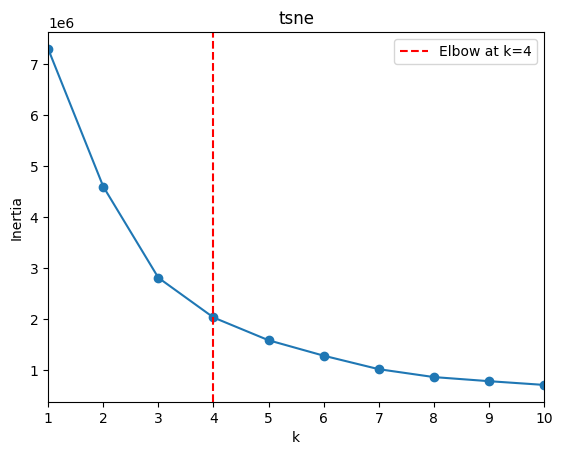

embeddings_kmeans.cluster_centers_.shape: (4, 2)


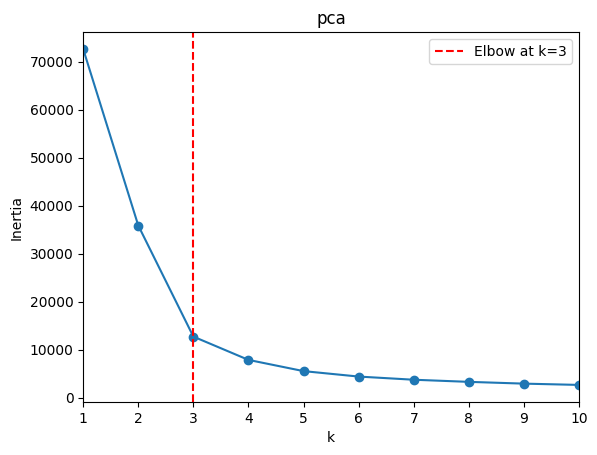

embeddings_kmeans.cluster_centers_.shape: (3, 2)


In [26]:
def calculate_kmeans(embeddings, n_clusters=None, max_k=5, title=None):
    if n_clusters:
        embeddings_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
    else:
        inertia = []
        k_iter = range(1, max_k + 1)
        embeddings_kmeans_list = []
        for k in k_iter:
            embeddings_kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(embeddings)
            embeddings_kmeans_list.append(embeddings_kmeans)
            inertia.append(embeddings_kmeans.inertia_)
        knee = KneeLocator(k_iter, inertia, curve="convex", direction="decreasing")
        embeddings_kmeans = embeddings_kmeans_list[knee.knee - 1]
        plt.plot(k_iter, inertia, marker="o")
        plt.axvline(x=knee.knee, color="r", linestyle="--", label=f"Elbow at k={knee.knee}")
        plt.xlabel("k")
        plt.ylabel("Inertia")
        plt.title(title)
        plt.legend()
        plt.xticks(k_iter)
        plt.xlim(1, max_k)
        plt.show()
    print("embeddings_kmeans.cluster_centers_.shape:", embeddings_kmeans.cluster_centers_.shape)
    return embeddings_kmeans


embeddings_kmeans_tsne = calculate_kmeans(embeddings_tsne, n_clusters=None, max_k=10, title="tsne")
embeddings_kmeans_pca = calculate_kmeans(embeddings_pca, n_clusters=None, max_k=10, title="pca")

# show_plot

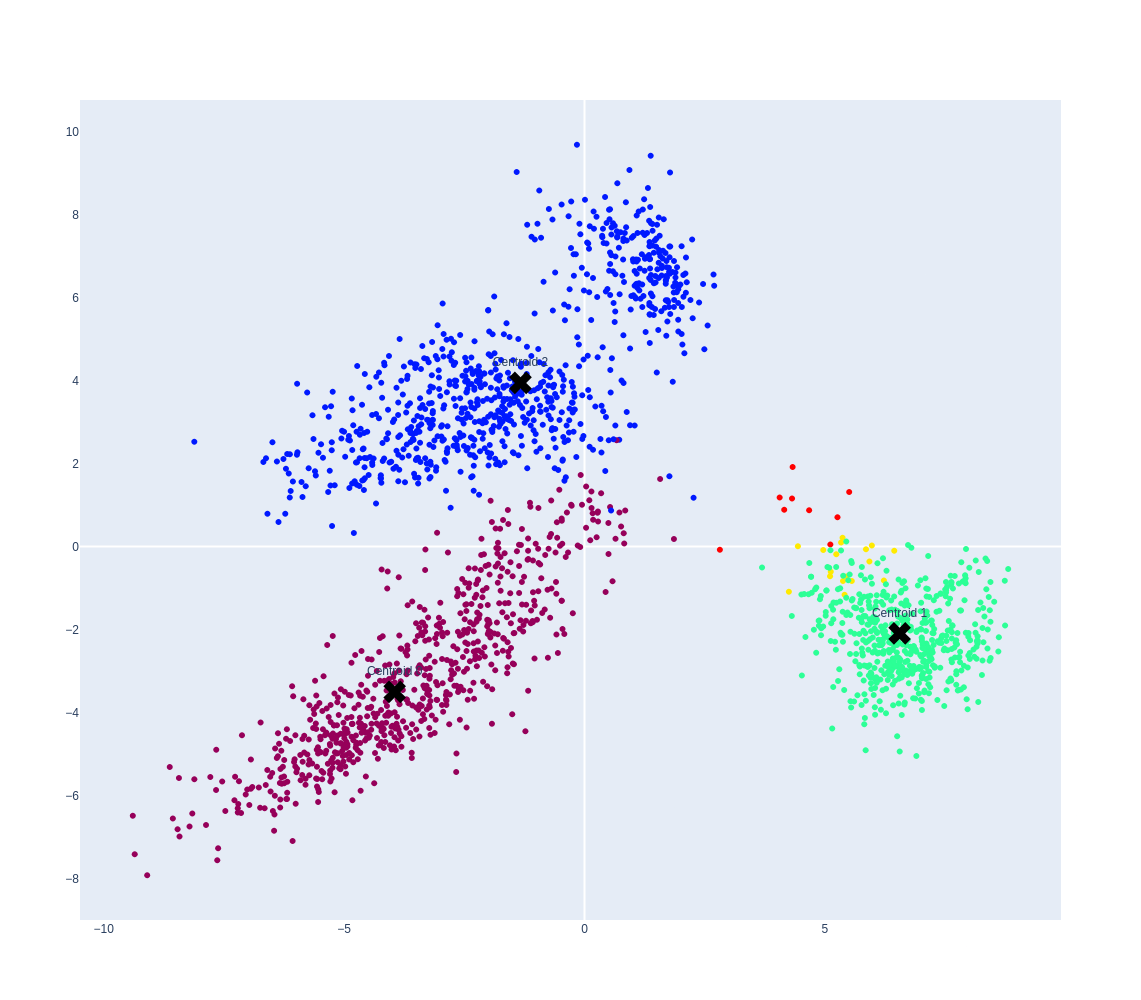

In [31]:
def show_plot(labels, embeddings, kmeans=None, title=None, show_labels=False, color_by=None):

    if kmeans:
        labels_new = []
        for label, cluster_id in zip(labels, kmeans.labels_):
            labels_new.append(label + "-centroid:" + str(cluster_id))
        labels = np.array(labels_new)

    if color_by:
        if color_by == "lemma":
            color_id_list = []
            color_id_dict = {}
            color_id_current = 0
            for l in labels:
                lemma = l.split("-")[0]
                color_id = color_id_dict.get(lemma)
                if color_id is None:
                    color_id = color_id_current
                    color_id_dict[lemma] = color_id
                    color_id_current += 1
                color_id_list.append(color_id)
        elif color_by == "kmeans":
            color_id_list = kmeans.labels_
        else:
            raise Exception('arg `color_by` must be either `"lemma"`, `"kmeans"`, or `None`')
    else:
        color_id_list = [0 for _ in embeddings]

    fig = go.Figure(
        data=go.Scatter(
            x=embeddings[:, 0],
            y=embeddings[:, 1],
            mode="markers",
            customdata=labels[:, np.newaxis],
            marker=dict(
                color=color_id_list,
                colorscale="rainbow",
            ),
            hovertemplate="x: %{x}<br>y: %{y}<br>label: %{customdata[0]}<extra></extra>",
            showlegend=False,
        ),
        layout=go.Layout(
            title=title,
            width=1000,
            height=1000,
            xaxis=dict(showgrid=False),
            yaxis=dict(showgrid=False),
        ),
    )
    if kmeans:
        for i, (cx, cy) in enumerate(kmeans.cluster_centers_):
            kmeans_label = f"Centroid {i}"
            fig.add_scatter(
                x=[cx],
                y=[cy],
                mode="markers+text",
                marker=dict(
                    color="black",
                    size=20,
                    symbol="x",
                ),
                text=[kmeans_label],
                textposition="top center",
                showlegend=False,
                hovertemplate="x: %{x}<br>y: %{y}<br>" + kmeans_label + "<extra></extra>",
            )
    fig.show()


show_plot(
    labels=labels,
    embeddings=embeddings_pca,
    kmeans=embeddings_kmeans_pca,
    show_labels=False,
    color_by="lemma",
)

# various experiments

**NOTE: Do not execute "experimental cells" below and then "production cells" above, as the cells below are not checked for potential overwriting of variables used in cells above**

## kmeans

### kmeans from scratch

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

np.random.seed(42)

In [10]:
k = 4

In [11]:
data_test, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.9, random_state=0)
print(data_test.shape)

(300, 2)


In [12]:
def init_centroids(data, k, debug_print=False):
    indices = np.random.choice(data.shape[0], size=k, replace=False)
    centroids = data[indices]
    if debug_print:
        print("-- init_centroids --")
        print(centroids.shape)
        print(centroids)
    return centroids


centroids_test = init_centroids(data_test, k, True)

-- init_centroids --
(4, 2)
[[-1.947065    1.64266676]
 [ 1.75426266  3.63583881]
 [-0.2778782   5.53219382]
 [-0.44252153  9.07292768]]


In [13]:
def assign_centroid(data, centroids, debug_print=False):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    data_centroids_indices = np.argmin(distances, axis=1)
    if debug_print:
        print("-- assign_centroid --")
        print("distances.shape:", distances.shape)
        print("distances[0]:", distances[0])
        print("data[0]:", data[0])
        print("centroids:", centroids)
        print(
            "np.linalg.norm(data[0] - centroids, axis=1):",
            np.linalg.norm(data[0] - centroids, axis=1),
        )
        print("data_centroids_indices[0]:", data_centroids_indices[0])
    return data_centroids_indices


data_centroids_indices_test = assign_centroid(data_test, centroids_test, True)

-- assign_centroid --
distances.shape: (300, 4)
distances[0]: [2.4430004  1.76215017 2.82213359 6.3526692 ]
data[0]: [0.2276515  2.75570724]
centroids: [[-1.947065    1.64266676]
 [ 1.75426266  3.63583881]
 [-0.2778782   5.53219382]
 [-0.44252153  9.07292768]]
np.linalg.norm(data[0] - centroids, axis=1): [2.4430004  1.76215017 2.82213359 6.3526692 ]
data_centroids_indices[0]: 1


In [14]:
def update_centroids(data, centroids, data_centroids_indices, debug_print=False):
    centroids_new = np.array([data[data_centroids_indices == i].mean(axis=0) for i in range(k)])
    if debug_print:
        print("-- update_centroids --")
        print("centroids:", centroids)
        print("centroids_new:", centroids_new)
    return centroids_new


centroids_new_test = update_centroids(data_test, centroids_test, data_centroids_indices_test, True)

-- update_centroids --
centroids: [[-1.947065    1.64266676]
 [ 1.75426266  3.63583881]
 [-0.2778782   5.53219382]
 [-0.44252153  9.07292768]]
centroids_new: [[-1.36677696  2.26219709]
 [ 1.73282234  2.34291985]
 [-0.58894072  5.53489617]
 [-1.43923493  8.12521409]]


In [15]:
def have_centroids_converged(centroids, centroids_new, threshold, debug_print=False):
    distances = np.linalg.norm(centroids - centroids_new, axis=1)
    have_centroids_converged = np.all(distances < threshold)
    if debug_print:
        print("-- have_centroids_converged --")
        print("distance:", distances)
        print("have_centroids_converged:", have_centroids_converged)
    return have_centroids_converged


centroids_converged_test = have_centroids_converged(centroids_test, centroids_new_test, True)

In [16]:
def kmeans_main(data, k, threshold=1e-1, debug_print=False):
    if debug_print:
        print("-- kmeans_main: start --")
    centroids = init_centroids(data, k, debug_print)
    centroids_converged = False
    while not centroids_converged:
        data_centroids_indices = assign_centroid(data, centroids, debug_print)
        centroids_new = update_centroids(data, centroids, data_centroids_indices, debug_print)
        centroids_converged = have_centroids_converged(
            centroids, centroids_new, threshold, debug_print
        )
        centroids = centroids_new
    if debug_print:
        print("-- kmeans_main: end --")
        print(centroids, data_centroids_indices)
    return centroids, data_centroids_indices


centroids, data_centroids_indices = kmeans_main(
    data=data_test, k=4, threshold=1e-4, debug_print=False
)

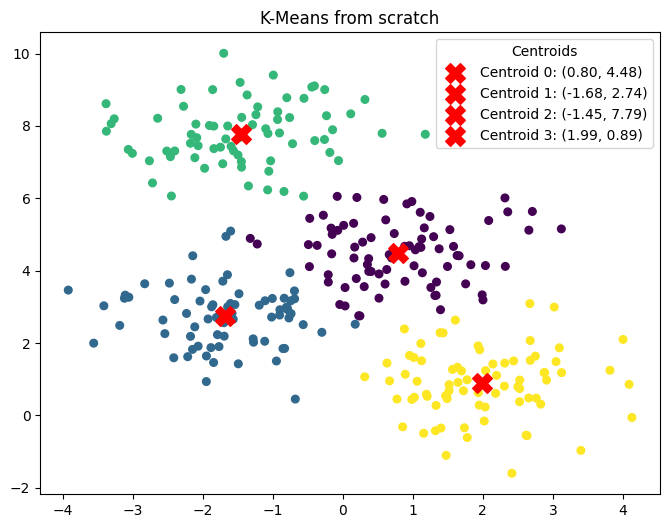

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(data_test[:, 0], data_test[:, 1], c=data_centroids_indices, cmap="viridis", s=30)
handles = []
labels_for_legend = []
for i, (x, y) in enumerate(centroids):
    handle = plt.scatter(x, y, color="red", s=200, marker="X")
    handles.append(handle)
    labels_for_legend.append(f"Centroid {i}: ({x:.2f}, {y:.2f})")
plt.legend(handles, labels_for_legend, title="Centroids", loc="best")
plt.title("K-Means from scratch")
plt.show()

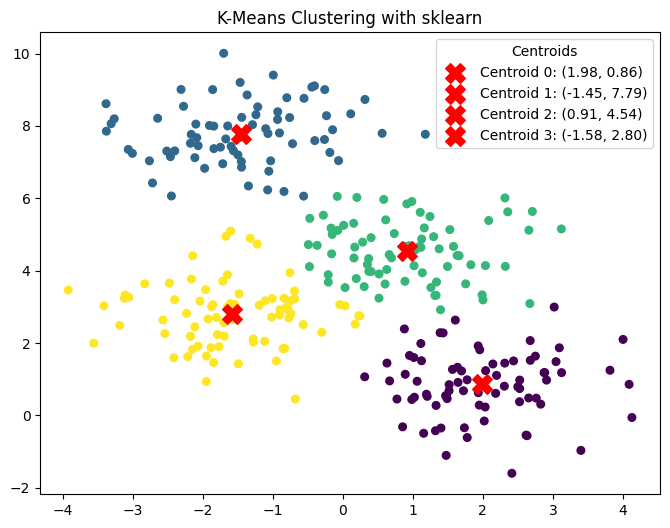

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_test)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(data_test[:, 0], data_test[:, 1], c=labels, cmap="viridis", s=30)
handles = []
labels_for_legend = []
for i, (x, y) in enumerate(centroids):
    handle = plt.scatter(x, y, color="red", s=200, marker="X")
    handles.append(handle)
    labels_for_legend.append(f"Centroid {i}: ({x:.2f}, {y:.2f})")
plt.legend(handles, labels_for_legend, title="Centroids", loc="best")
plt.title("K-Means Clustering with sklearn")
plt.show()

### kmeans visualizations

(300, 2)


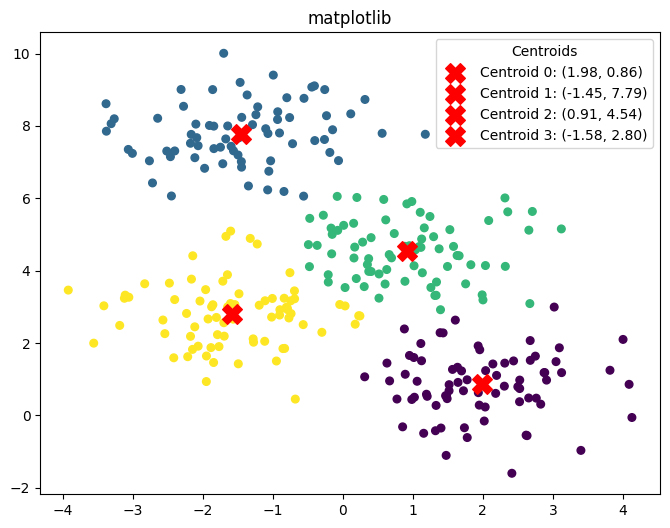

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

data_test, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.9, random_state=0)
print(data_test.shape)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_test)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(data_test[:, 0], data_test[:, 1], c=labels, cmap="viridis", s=30)
handles = []
labels_for_legend = []
for i, (x, y) in enumerate(centroids):
    handle = plt.scatter(x, y, color="red", s=200, marker="X")
    handles.append(handle)
    labels_for_legend.append(f"Centroid {i}: ({x:.2f}, {y:.2f})")
plt.legend(handles, labels_for_legend, title="Centroids", loc="best")
plt.title("matplotlib")
plt.show()

(300, 2)


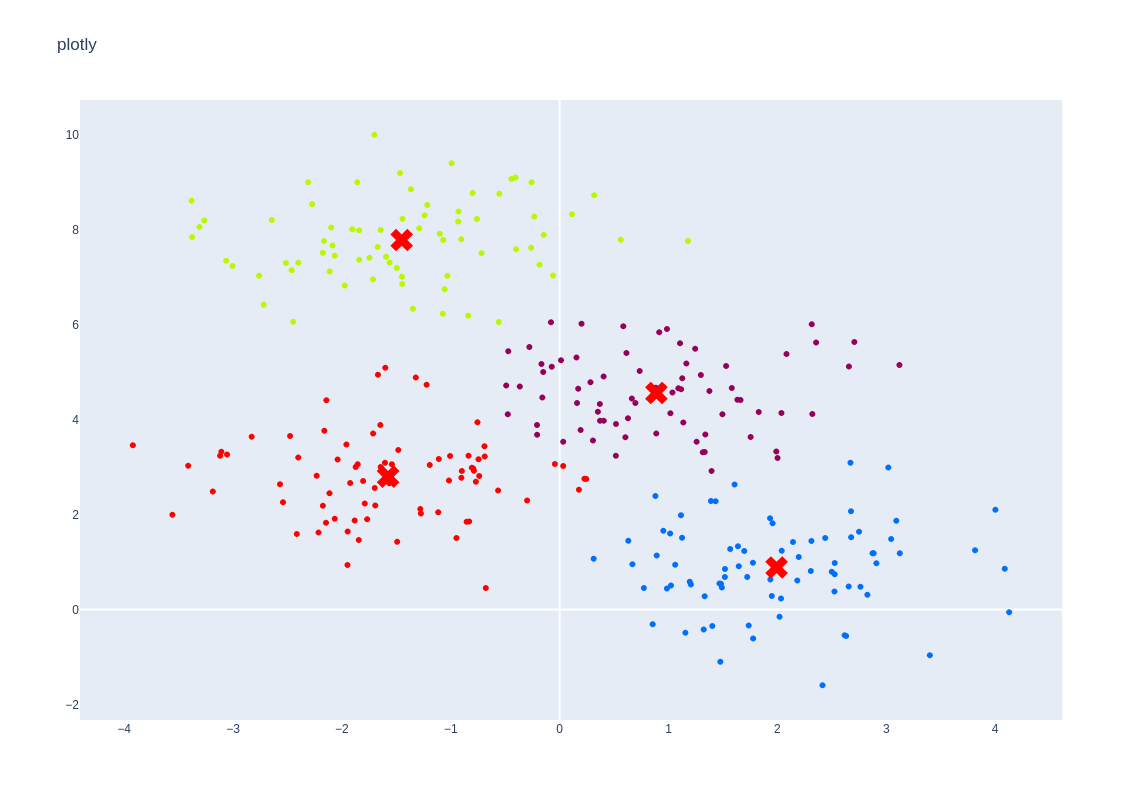

In [18]:
import numpy as np
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

data_test, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.9, random_state=0)
print(data_test.shape)

kmeans = KMeans(n_clusters=4, random_state=0).fit(data_test)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig = go.Figure(
    data=go.Scatter(
        x=data_test[:, 0],
        y=data_test[:, 1],
        mode="markers",
        marker=dict(
            color=labels,
            colorscale="rainbow",
        ),
        hovertemplate="x: %{x}<br>y: %{y}<extra></extra>",
        showlegend=False,
    ),
    layout=go.Layout(
        title="plotly",
        width=800,
        height=800,
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
    ),
)
for i, (cx, cy) in enumerate(centroids):
    fig.add_scatter(
        x=[cx],
        y=[cy],
        mode="markers+text",
        marker=dict(
            color="red",
            size=20,
            symbol="x",
        ),
        text=[f"Centroid {i}"],
        textposition="top center",
        showlegend=False,
        hovertemplate="x: %{x}<br>y: %{y}<extra></extra>",
    )

fig.show()

### elbow method

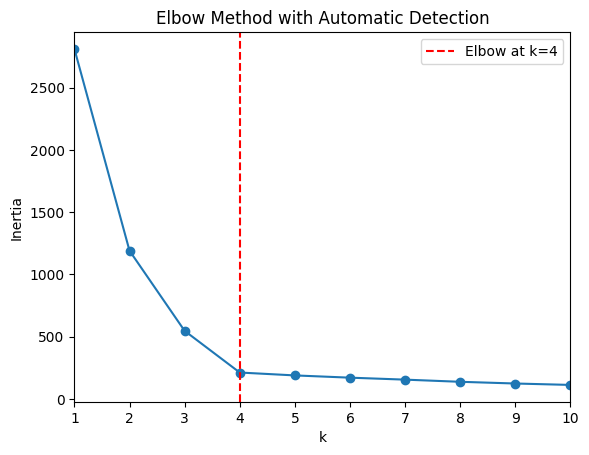

Optimal number of clusters (Elbow): 4


In [21]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)

inertia = []
K = range(1, 11)

for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=0)
    model.fit(X)
    inertia.append(model.inertia_)

# Find elbow point
knee = KneeLocator(K, inertia, curve="convex", direction="decreasing")

# Plot
plt.plot(K, inertia, marker="o")
plt.axvline(x=knee.knee, color="r", linestyle="--", label=f"Elbow at k={knee.knee}")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method with Automatic Detection")
plt.legend()
plt.xticks(K)
plt.xlim(1, 10)
plt.show()
print(f"Optimal number of clusters (Elbow): {knee.knee}")

## snippets to be removed

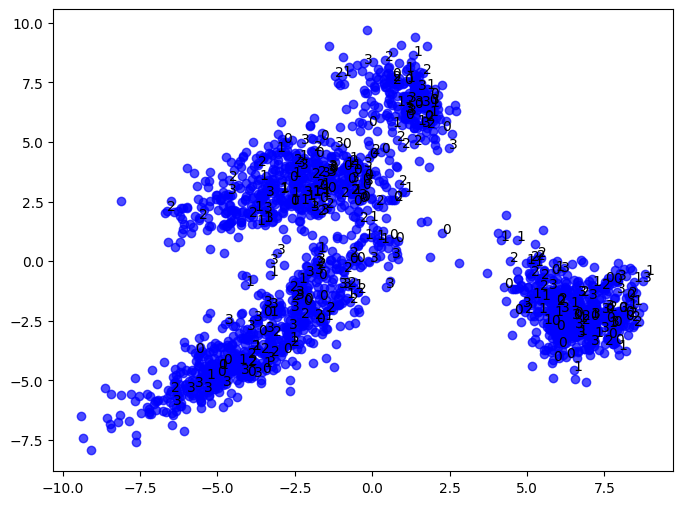

In [22]:
def show_plot_pca(labels, embeddings, title=None):
    pca = PCA(n_components=2)
    embeddings_reduced = pca.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], color="blue", alpha=0.7)
    for r, l in zip(embeddings_reduced, labels):
        plt.text(r[0], r[1], l)
    plt.title(title)
    plt.show()


show_plot_pca(labels, embeddings)

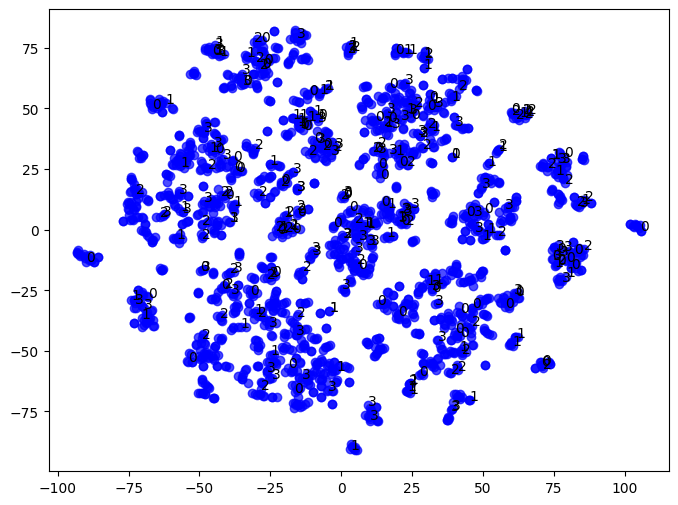

In [23]:
def show_plot_tsne(labels, embeddings, title=None):
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    embeddings_reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c="blue", alpha=0.7)
    for i, label in enumerate(labels):
        plt.text(
            embeddings_reduced[i, 0],
            embeddings_reduced[i, 1],
            label,
        )
    plt.title(title)
    plt.show()


show_plot_tsne(labels, embeddings)